<a href="https://colab.research.google.com/github/fininsight/nlp-deeplearning-tutorial/blob/master/06_Prac_RNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#6장. RNN

#1 RNN(LSTM)을 사용한 텍스트 분류

https://www.tensorflow.org/tutorials/text/text_classification_rnn?hl=ko

##1) 공통

In [1]:
import tensorflow_datasets as tfds
import tensorflow as tf

In [2]:
import matplotlib.pyplot as plt

def plot_graphs(history, metric):
  plt.plot(history.history[metric])
  plt.plot(history.history['val_'+metric], '')
  plt.xlabel("Epochs")
  plt.ylabel(metric)
  plt.legend([metric, 'val_'+metric])
  plt.show()

##2)  IMDB 데이터셋 (긍정/부정) 다운로드

In [ ]:
dataset, info = tfds.load('imdb_reviews/subwords8k', with_info=True, as_supervised=True)
train_dataset, test_dataset = dataset['train'], dataset['test']

Shuffling and writing examples to /root/tensorflow_datasets/imdb_reviews/subwords8k/1.0.0.incompleteSFKNBX/imdb_reviews-train.tfrecord


### SubwordTextEncoder

In [ ]:
encoder = info.features['text'].encoder #tfds.features.text.SubwordTextEncoder
print('Vocabulary size: {}'.format(encoder.vocab_size))

In [ ]:
sample_string = 'Hello TensorFlow.'

encoded_string = encoder.encode(sample_string) #문자열을 인코딩
print('Encoded string is {}'.format(encoded_string)) 

original_string = encoder.decode(encoded_string) #인코딩된 리스트를 문자열로 디코딩
print('The original string: "{}"'.format(original_string))

In [ ]:
assert original_string == sample_string

In [ ]:
#subword로 구성되어있음을 확인
for index in encoded_string:
  print('{} ----> {}'.format(index, encoder.decode([index])))

## 3) 학습데이터 준비

Next create batches of these encoded strings. Use the `padded_batch` method to zero-pad the sequences to the length of the longest string in the batch:

In [ ]:
BUFFER_SIZE = 10000
BATCH_SIZE = 64

In [ ]:
train_dataset = train_dataset.shuffle(BUFFER_SIZE)
train_dataset = train_dataset.padded_batch(BATCH_SIZE)

test_dataset = test_dataset.padded_batch(BATCH_SIZE)

In [ ]:
train_dataset?

##4) 모델 정의

In [ ]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(encoder.vocab_size, 64),
    tf.keras.layers.LSTM(64),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1)
])

In [ ]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

## 5) 모델 학습

In [ ]:
history = model.fit(train_dataset, epochs=10,
                    validation_data=test_dataset, 
                    validation_steps=30)

Epoch 1/10
391/391 [==============================] - 793s 2s/step - loss: 0.6918 - accuracy: 0.5000 - val_loss: 0.6907 - val_accuracy: 0.4917
Epoch 2/10
391/391 [==============================] - 809s 2s/step - loss: 0.5290 - accuracy: 0.6831 - val_loss: 0.3867 - val_accuracy: 0.8260
Epoch 3/10
391/391 [==============================] - 796s 2s/step - loss: 0.2933 - accuracy: 0.8828 - val_loss: 0.3376 - val_accuracy: 0.8677
Epoch 4/10
391/391 [==============================] - 804s 2s/step - loss: 0.2343 - accuracy: 0.9116 - val_loss: 0.3347 - val_accuracy: 0.8693
Epoch 5/10
391/391 [==============================] - 802s 2s/step - loss: 0.2011 - accuracy: 0.9262 - val_loss: 0.3475 - val_accuracy: 0.8620
Epoch 6/10
391/391 [==============================] - 807s 2s/step - loss: 0.1731 - accuracy: 0.9399 - val_loss: 0.3548 - val_accuracy: 0.8625
Epoch 7/10
391/391 [==============================] - 800s 2s/step - loss: 0.1564 - accuracy: 0.9470 - val_loss: 0.4307 - val_accuracy: 0.8625

In [ ]:
test_loss, test_acc = model.evaluate(test_dataset)

print('Test Loss: {}'.format(test_loss))
print('Test Accuracy: {}'.format(test_acc))

391/391 [==============================] - 166s 424ms/step - loss: 0.3927 - accuracy: 0.8532
Test Loss: 0.39266476035118103
Test Accuracy: 0.8532000184059143


##6) 예측 및 평가

In [ ]:
def pad_to_size(vec, size):
  zeros = [0] * (size - len(vec))
  vec.extend(zeros)
  return vec

In [ ]:
def sample_predict(sample_pred_text, pad):
  encoded_sample_pred_text = encoder.encode(sample_pred_text)

  if pad:
    encoded_sample_pred_text = pad_to_size(encoded_sample_pred_text, 64)
  encoded_sample_pred_text = tf.cast(encoded_sample_pred_text, tf.float32)
  predictions = model.predict(tf.expand_dims(encoded_sample_pred_text, 0))

  return (predictions)

In [ ]:
# predict on a sample text without padding.

sample_pred_text = ('The movie was cool. The animation and the graphics '
                    'were out of this world. I would recommend this movie.')
predictions = sample_predict(sample_pred_text, pad=False)
print(predictions)

[[-0.22795033]]


In [ ]:
# predict on a sample text with padding

sample_pred_text = ('The movie was cool. The animation and the graphics '
                    'were out of this world. I would recommend this movie.')
predictions = sample_predict(sample_pred_text, pad=True)
print(predictions)

[[0.03443048]]


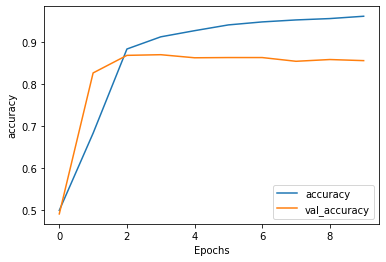

In [ ]:
plot_graphs(history, 'accuracy')

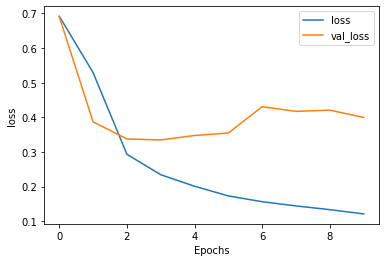

In [ ]:
plot_graphs(history, 'loss')

---

#2 GRU

##1) 모델 정의

In [ ]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(encoder.vocab_size, 64),
    tf.keras.layers.Bidirectional(tf.keras.layers.GRU(64)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1)
])

##2) 모델 학습

In [ ]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

In [ ]:
history = model.fit(train_dataset, epochs=10,
                    validation_data=test_dataset,
                    validation_steps=30)

Epoch 1/10
391/391 [==============================] - 1468s 4s/step - loss: 0.6644 - accuracy: 0.5397 - val_loss: 0.4946 - val_accuracy: 0.7807
Epoch 2/10
391/391 [==============================] - 1514s 4s/step - loss: 0.3717 - accuracy: 0.8434 - val_loss: 0.3705 - val_accuracy: 0.8406
Epoch 3/10
391/391 [==============================] - 1518s 4s/step - loss: 0.2583 - accuracy: 0.9038 - val_loss: 0.3709 - val_accuracy: 0.8427
Epoch 4/10
391/391 [==============================] - 1518s 4s/step - loss: 0.2132 - accuracy: 0.9259 - val_loss: 0.3968 - val_accuracy: 0.8542
Epoch 5/10
370/391 [===========================>..] - ETA: 1:20 - loss: 0.1830 - accuracy: 0.9376

##3) 예측 및 평가

In [ ]:
test_loss, test_acc = model.evaluate(test_dataset)

print('Test Loss: {}'.format(test_loss))
print('Test Accuracy: {}'.format(test_acc))

In [ ]:
# predict on a sample text without padding.

sample_pred_text = ('The movie was not good. The animation and the graphics '
                    'were terrible. I would not recommend this movie.')
predictions = sample_predict(sample_pred_text, pad=False)
print(predictions)

In [ ]:
# predict on a sample text with padding

sample_pred_text = ('The movie was not good. The animation and the graphics '
                    'were terrible. I would not recommend this movie.')
predictions = sample_predict(sample_pred_text, pad=True)
print(predictions)

In [ ]:
plot_graphs(history, 'accuracy')

In [ ]:
plot_graphs(history, 'loss')

---

#3 LSTM Bidirectional

##1) 모델 정의

In [ ]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(encoder.vocab_size, 64),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1)
])

##2) 모델 학습

In [ ]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

In [ ]:
history = model.fit(train_dataset, epochs=10,
                    validation_data=test_dataset,
                    validation_steps=30)

Epoch 1/10
391/391 [==============================] - 1468s 4s/step - loss: 0.6644 - accuracy: 0.5397 - val_loss: 0.4946 - val_accuracy: 0.7807
Epoch 2/10
391/391 [==============================] - 1514s 4s/step - loss: 0.3717 - accuracy: 0.8434 - val_loss: 0.3705 - val_accuracy: 0.8406
Epoch 3/10
391/391 [==============================] - 1518s 4s/step - loss: 0.2583 - accuracy: 0.9038 - val_loss: 0.3709 - val_accuracy: 0.8427
Epoch 4/10
391/391 [==============================] - 1518s 4s/step - loss: 0.2132 - accuracy: 0.9259 - val_loss: 0.3968 - val_accuracy: 0.8542
Epoch 5/10
370/391 [===========================>..] - ETA: 1:20 - loss: 0.1830 - accuracy: 0.9376

##3) 예측 및 평가

In [ ]:
test_loss, test_acc = model.evaluate(test_dataset)

print('Test Loss: {}'.format(test_loss))
print('Test Accuracy: {}'.format(test_acc))

In [ ]:
# predict on a sample text without padding.

sample_pred_text = ('The movie was not good. The animation and the graphics '
                    'were terrible. I would not recommend this movie.')
predictions = sample_predict(sample_pred_text, pad=False)
print(predictions)

In [ ]:
# predict on a sample text with padding

sample_pred_text = ('The movie was not good. The animation and the graphics '
                    'were terrible. I would not recommend this movie.')
predictions = sample_predict(sample_pred_text, pad=True)
print(predictions)

In [ ]:
plot_graphs(history, 'accuracy')

In [ ]:
plot_graphs(history, 'loss')

---

#4 LSTM Stacking

##1) 모델 정의

In [ ]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(encoder.vocab_size, 64),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64,  return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1)
])

##2) 모델 학습

In [ ]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

In [ ]:
history = model.fit(train_dataset, epochs=10,
                    validation_data=test_dataset,
                    validation_steps=30)

Epoch 1/10
391/391 [==============================] - 1468s 4s/step - loss: 0.6644 - accuracy: 0.5397 - val_loss: 0.4946 - val_accuracy: 0.7807
Epoch 2/10
391/391 [==============================] - 1514s 4s/step - loss: 0.3717 - accuracy: 0.8434 - val_loss: 0.3705 - val_accuracy: 0.8406
Epoch 3/10
391/391 [==============================] - 1518s 4s/step - loss: 0.2583 - accuracy: 0.9038 - val_loss: 0.3709 - val_accuracy: 0.8427
Epoch 4/10
391/391 [==============================] - 1518s 4s/step - loss: 0.2132 - accuracy: 0.9259 - val_loss: 0.3968 - val_accuracy: 0.8542
Epoch 5/10
370/391 [===========================>..] - ETA: 1:20 - loss: 0.1830 - accuracy: 0.9376

##3) 예측 및 평가

In [ ]:
test_loss, test_acc = model.evaluate(test_dataset)

print('Test Loss: {}'.format(test_loss))
print('Test Accuracy: {}'.format(test_acc))

In [ ]:
# predict on a sample text without padding.

sample_pred_text = ('The movie was not good. The animation and the graphics '
                    'were terrible. I would not recommend this movie.')
predictions = sample_predict(sample_pred_text, pad=False)
print(predictions)

In [ ]:
# predict on a sample text with padding

sample_pred_text = ('The movie was not good. The animation and the graphics '
                    'were terrible. I would not recommend this movie.')
predictions = sample_predict(sample_pred_text, pad=True)
print(predictions)

In [ ]:
plot_graphs(history, 'accuracy')

In [ ]:
plot_graphs(history, 'loss')